# To-Do: Filter Noisy Pixels in FITS Files

### Objective:
Filter out noisy pixels using the condition:  
`counts > median counts + n × sigma` (using `astropy`).

### Steps:
1. **Process a Single File:**
    - Start with one FITS file.
    - Perform filtering at the levels of:
        - Quadrant  
        - Detector  
        - Pixel  
    - Apply the noisy condition (`counts > median counts + n × sigma`).
    - Generate bar plots showing:
        - Pixel number vs. how often it appears noisy across files.
    
2. **Extend to Multiple Files:**
    - Create a loop to process multiple FITS files.
    - Apply the above conditions for each file.
    
3. **Testing:**
    - Run the process for a few files.
    - Evaluate results for accuracy.

4. **Final Steps:**
    - Implement the filtering in a complete loop for all files.
    - Validate the results after automation.


detID: 0, Bad Pixels: [98, 175], Counts: [5628787  334288], Fraction of counts from noisy pixels: [93.  6.] %
0, 98, 5628787, 0.935
0, 175, 334288, 0.056
detID: 1, Bad Pixels: [7], Counts: [15827], Fraction of counts from noisy pixels: [21.] %
1, 7, 15827, 0.205
detID: 2, Bad Pixels: [], Counts: [], Fraction of counts from noisy pixels: [] %
detID: 3, Bad Pixels: [1, 14, 29, 46, 62, 99, 114, 115, 130, 131], Counts: [ 99398  30756  50945  14354  13497 511123  48030  29716 436212 272035], Fraction of counts from noisy pixels: [ 6.  2.  3.  1.  1. 32.  3.  2. 27. 17.] %
3, 1, 99398, 0.062
3, 14, 30756, 0.019
3, 29, 50945, 0.032
3, 46, 14354, 0.009
3, 62, 13497, 0.008
3, 99, 511123, 0.318
3, 114, 48030, 0.030
3, 115, 29716, 0.018
3, 130, 436212, 0.271
3, 131, 272035, 0.169
detID: 4, Bad Pixels: [3, 77, 92, 93, 156, 204, 205, 249], Counts: [  37644   16164 1350182   36906   23695  185820   51361   14899], Fraction of counts from noisy pixels: [ 2.  1. 75.  2.  1. 10.  3.  1.] %
4, 3, 37644,

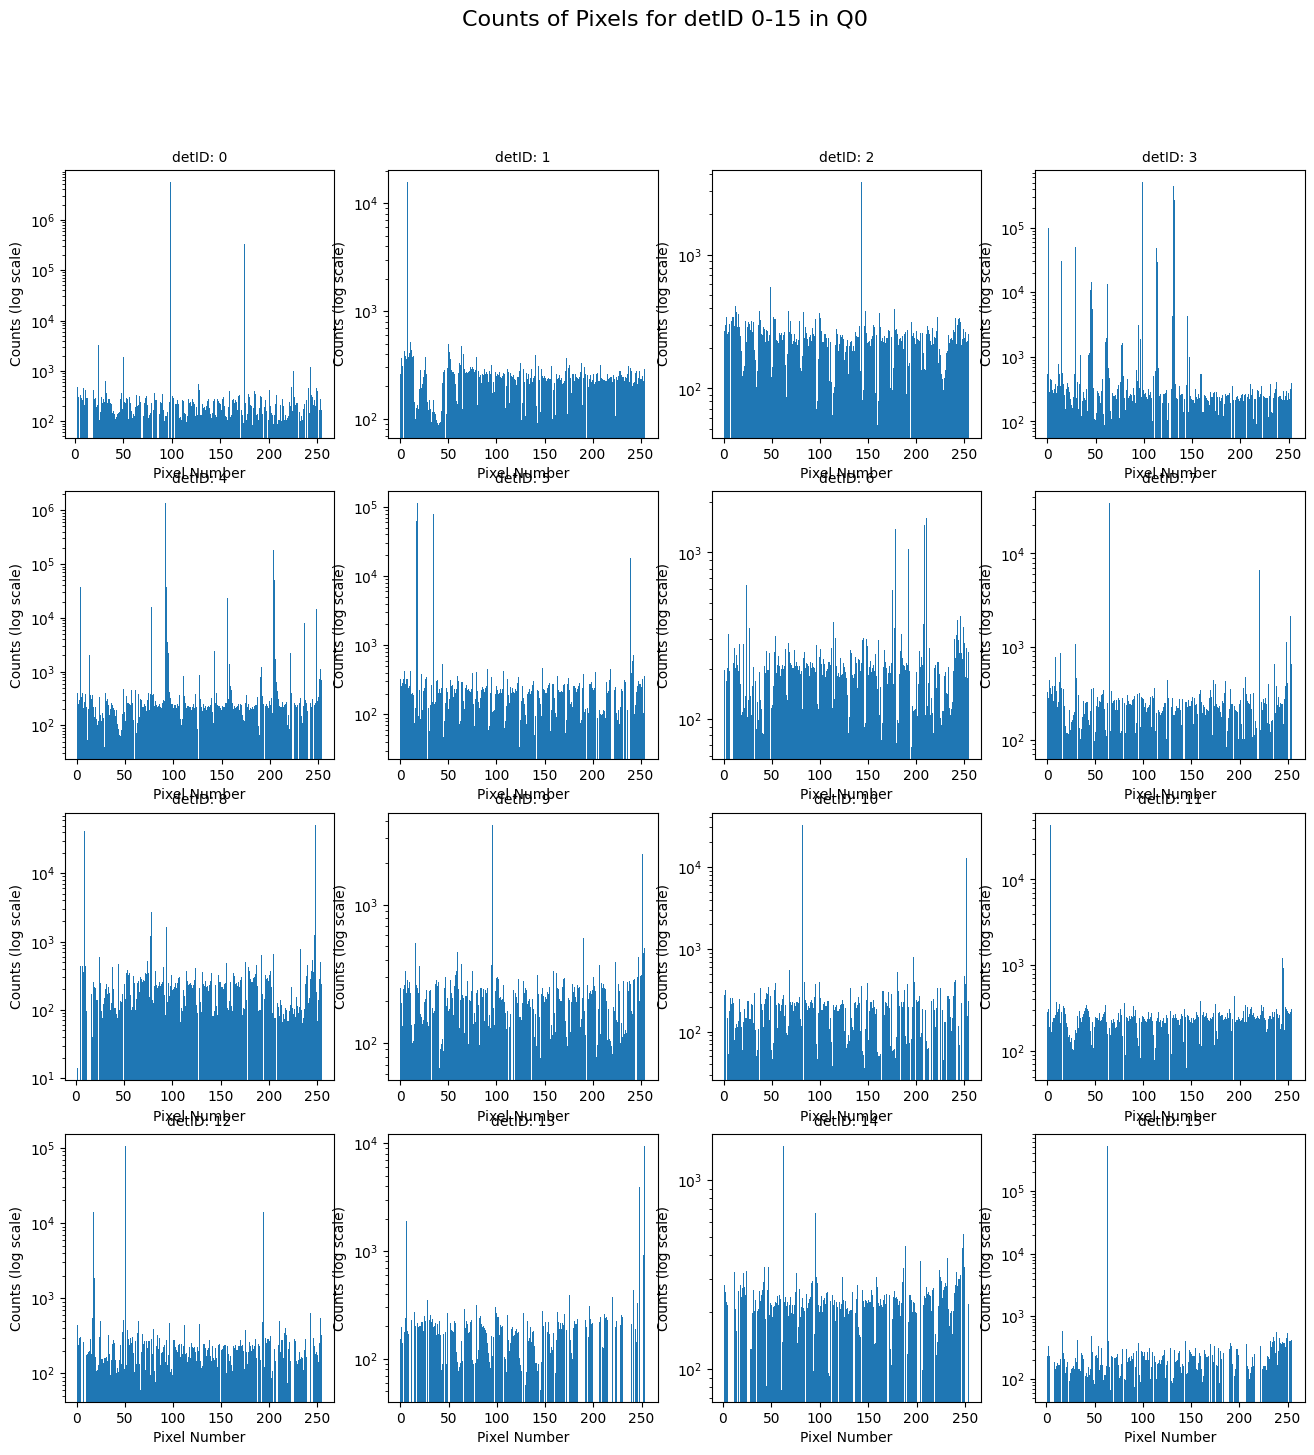

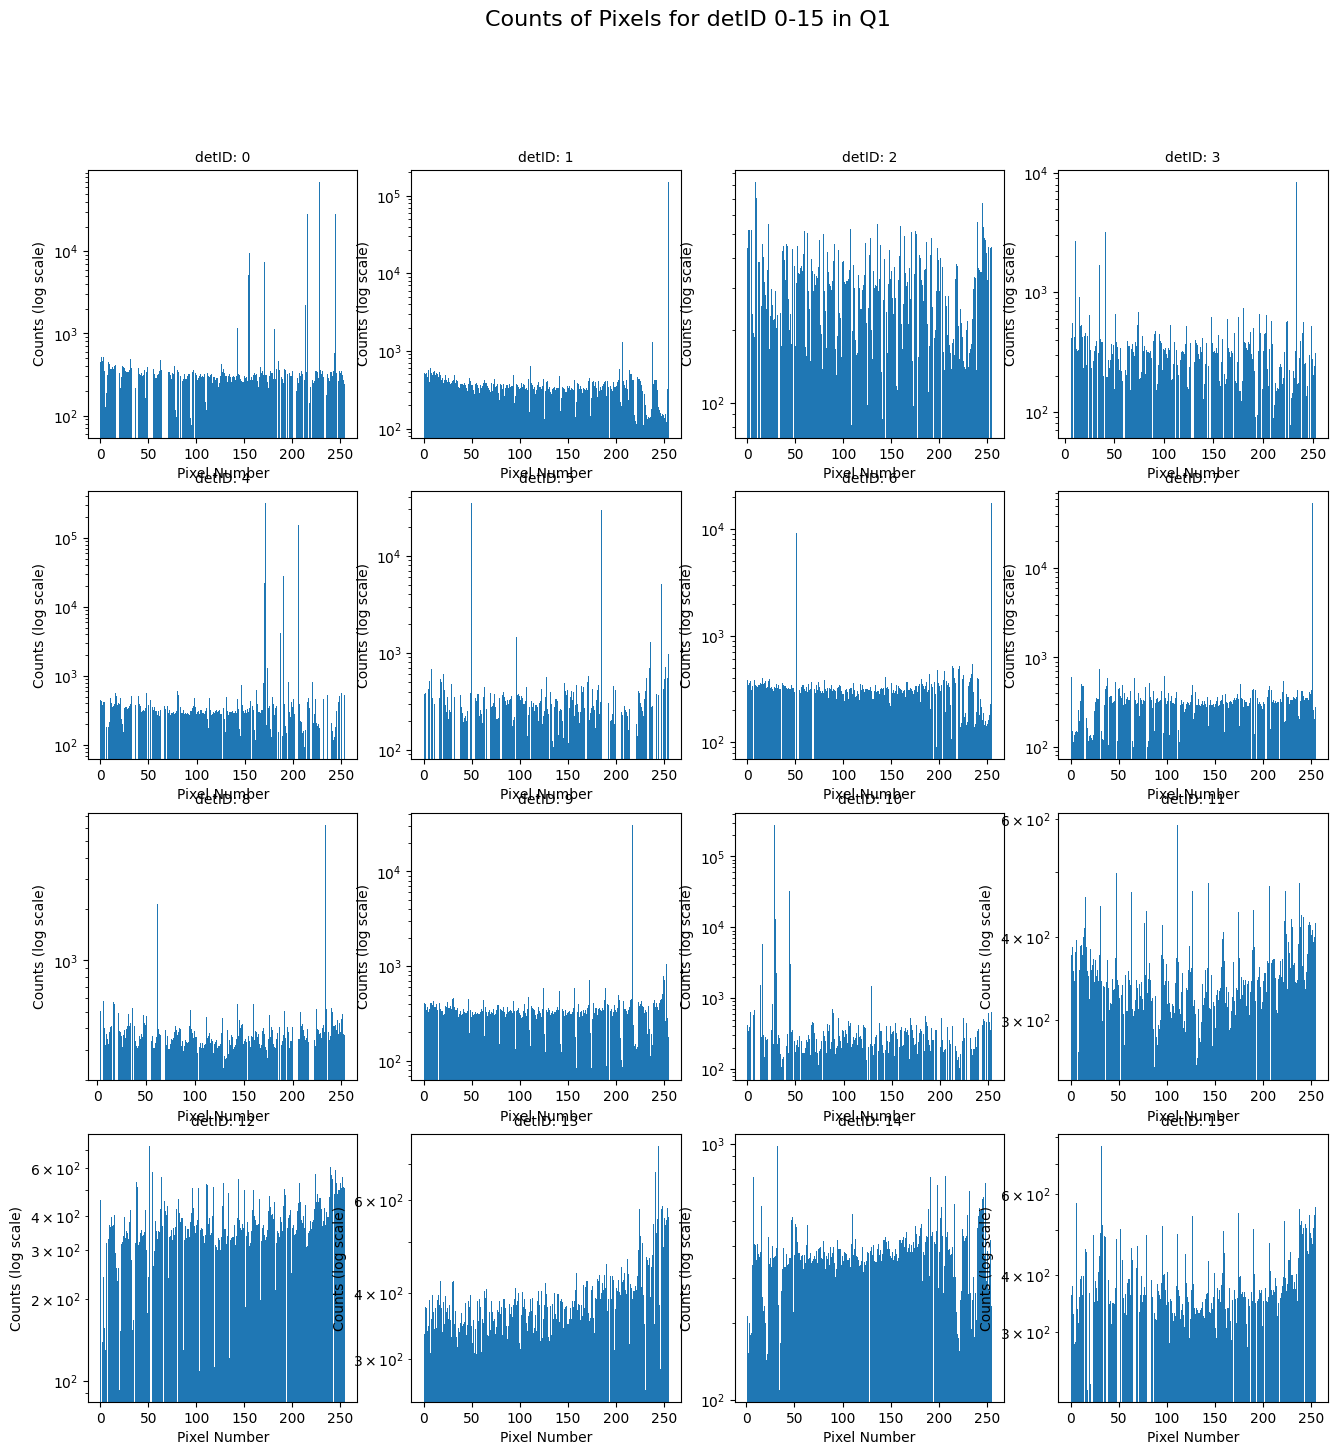

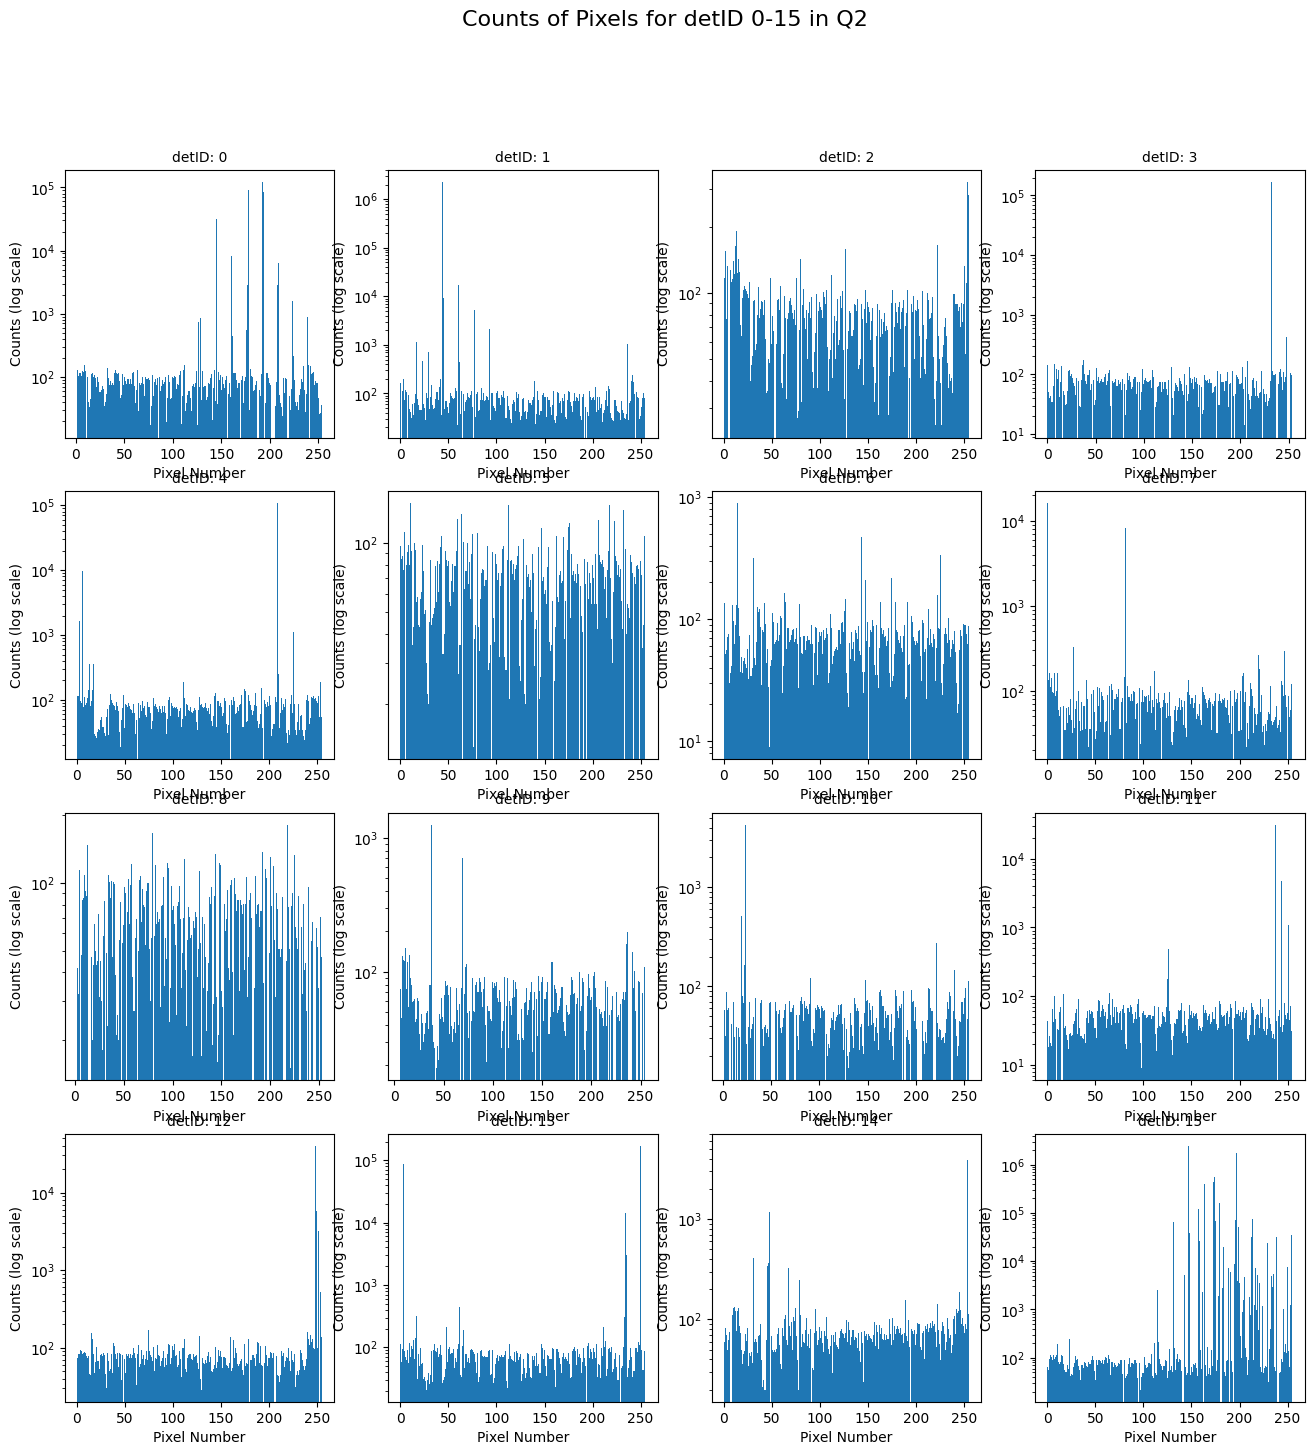

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import os

# Input data filee
openfile_path = "/home/czti/bc_evevent_file.txt"
#output directory
output_dir = "/home/czti/user_area/anuraag/CZTI_report/"

data_file = pd.read_csv(openfile_path, sep=" ", header=None)
n_files = 1  # Adjust based on your needs (length of data_file)
hdulist = fits.open(data_file[0][0])
selected_quad = 0 # Quadrant to process (0-3)
for selected_quad in range(selected_quad, selected_quad + 4, 1):
    quadrant = f'Q{selected_quad}'
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

    # Output CSV file
    output_csv_path = f"{output_dir}bad_pixels_quad{quadrant}.csv"

    # Prepare the CSV file (write header once)
    # with open(output_csv_path, 'w') as f:
    #     f.write("Quadrant,detID,Bad Pixels,Counts,Reference_counts,noisy_pix_memory_size\n")
    outfile = open(output_csv_path, 'w')
    outfile.write("quad,detID,pixID,count,frac_counts\n")
    # Get data for the selected quadrant
    data = hdulist[quadrant].data

    # Create a figure with 4x4 subplots
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
    fig.suptitle(f"Counts of Pixels for detID 0-15 in {quadrant}", fontsize=16)

    # Iterate over detIDs and process
    for i in range(16):
        ax = axes[i // 4, i % 4]  # Determine the subplot location
        det_id = data[data['detID'] == i]
        pix_data = det_id['pixID']
        
        # Finding the mean and standard deviation of the pixel counts
        pix_counts = np.bincount(pix_data, minlength=256)
        mean_pix_counts, median_pix_counts, std_pix_counts = sigma_clipped_stats(pix_counts, sigma=3)
        
        # Identify bad pixels
        bad_pixels = [idx for idx, val in enumerate(pix_counts) if val > mean_pix_counts + 100 * std_pix_counts]
        #print(f"detID: {i}, Bad Pixels: {bad_pixels}, Counts: {pix_counts[bad_pixels]}, Mean: {mean_pix_counts}, Median: {median_pix_counts}, Std: {std_pix_counts}")
        memory_used_by_noisy_pixels = np.round(pix_counts[bad_pixels] / np.sum(pix_counts) * 100) 
        print(f"detID: {i}, Bad Pixels: {bad_pixels}, Counts: {pix_counts[bad_pixels]}, Fraction of counts from noisy pixels: {memory_used_by_noisy_pixels} %")
        for pix in bad_pixels:
            frac_counts = pix_counts[pix] / np.sum(pix_counts)
            print(f"{selected_quad}, {i}, {pix}, {pix_counts[pix]}, {frac_counts:0.3f}")
        # Append data to the CSV
        # with open(output_csv_path, 'a') as f:
            # f.write(f"{quadrant}, {i}, {bad_pixels}, {pix_counts[bad_pixels]}, [Mean: {int(mean_pix_counts)}, Median: {int(median_pix_counts)}, Std: {int(std_pix_counts)}], {memory_used_by_noisy_pixels}%\n")
        outfile.write(f"{selected_quad}, {i}, {pix}, {pix_counts[pix]}, {frac_counts:0.3}\n")
        # Plot histogram for the detector
        ax.hist(pix_data, bins=256)
        ax.set_yscale('log')
        ax.set_xlabel("Pixel Number")
        ax.set_ylabel("Counts (log scale)")
        ax.set_title(f"detID: {i}", fontsize=10)
    outfile.close()

# Adjust layout to prevent overlap and save the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])
output_pdf_path = f"{output_dir}CZTI_pixel_counts_{quadrant}.png"
plt.savefig(output_pdf_path, dpi=300)
plt.close()

print(f"Bad pixel data saved to {output_csv_path}")
print(f"Pixel count plots saved to {output_pdf_path}")


168.21386998567334

# Filtering:
- open file 
    - see the header of the events files
    - choose data with quadrant 
- select data for one quadrant
    -  select detID 
    -  select pixID
- take histogram of pixID
    - take the counts of pixels 
    - that is an array of length that tells how many times pixels occurs on pixel
- now apply sigma clipping and calcualte...
    - calculate the median and sigma of counts
    - declare the Pixel noisy using the condition with counts > median + n Sigma 
        - n is the a condition to select the outlayer level
    - generate a pdf file quadrant-wise having bar graphs of pixels vs noisy declared pixels per file for all detectors in the quadrant
    - save the pdf with the format of 16 plots on the each page according to quadrants 

In [11]:
import glob

In [18]:
file = glob.glob("/home/czti/user_area/gaurav/czti_debug/20241208_A13_037T01_9000006440_level2/czti/orbit/*/*/*bc.evt")
print(file[1])

/home/czti/user_area/gaurav/czti_debug/20241208_A13_037T01_9000006440_level2/czti/orbit/49843_V1.0/modeM0/AS1A13_037T01_9000006440_49843cztM0_level2_bc.evt
